# Introduction

This notebook is divided into two parts:

__Part I - Prepocessing of images__, was applied as such for all the models we used for training the emotion detection. Therefore the same code is also built into other jupyter notebooks. The code is taken from the notebook 'emotion_detection_VGG16'.

__Part II - Metrics Calculation for saved VGG16()-models__  






# Part I - Preprocessing of the images

In [1]:
!pip install imblearn

In [2]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# run locally
# Basis-Dateipfad
#base_path = r'C:\Users\steff\OneDrive - Hochschule Luzern\Dokumente\HSLU\Computer Vision\Project CV all\Emotion Classification\data\images\images\train'
#base_path = r'C:\Users\eli\Nextcloud\HSLU\Vorlesungen\Computer_Vision_CVI03\Project\images\images\train'   # Desktop E


In [3]:

def read_data(base_path):
    # Liste der Ordner mit Labels
    folders = [
        'angry',
        'disgust',
        'fear',
        'happy',
        'neutral',
        'sad',
        'surprise'
    ]

    # Initialisiere leere Listen für Bilder und Labels
    df=pd.DataFrame(columns=["images","labels"])

    # Iteriere durch die Ordner und sammle Bilder und Labels
    i=0
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            image_files = os.listdir(folder_path)
            image_files.sort()
            for image_file in image_files:
                image_path = os.path.join(folder_path, image_file)
                # Öffne das Bild und speichere es im RGB-Format
                image = Image.open(image_path)#.convert('RGB')
                # Wandele das Bild in ein NumPy-Array um
                image = np.array(image)
                df.loc[i,"images"]=image
                df.loc[i,"labels"]=folder
                i+=1

    return df


In [ ]:
# run locally
#train_path = './images/train'
#test_path = './images/validation'
#train_df = read_data(train_path)
#test_df=read_data(test_path)
#df=pd.concat([train_df,test_df])

In [4]:
# run on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# run on colab
#train_path = '../Data/Emotions/train'
#test_path = '../Data/Emotions/validation'

train_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/train'
test_path = '../content/drive/MyDrive/ComputerVision/Data/Emotions/validation'
train_df = read_data(train_path)
test_df=read_data(test_path)
df=pd.concat([train_df,test_df])

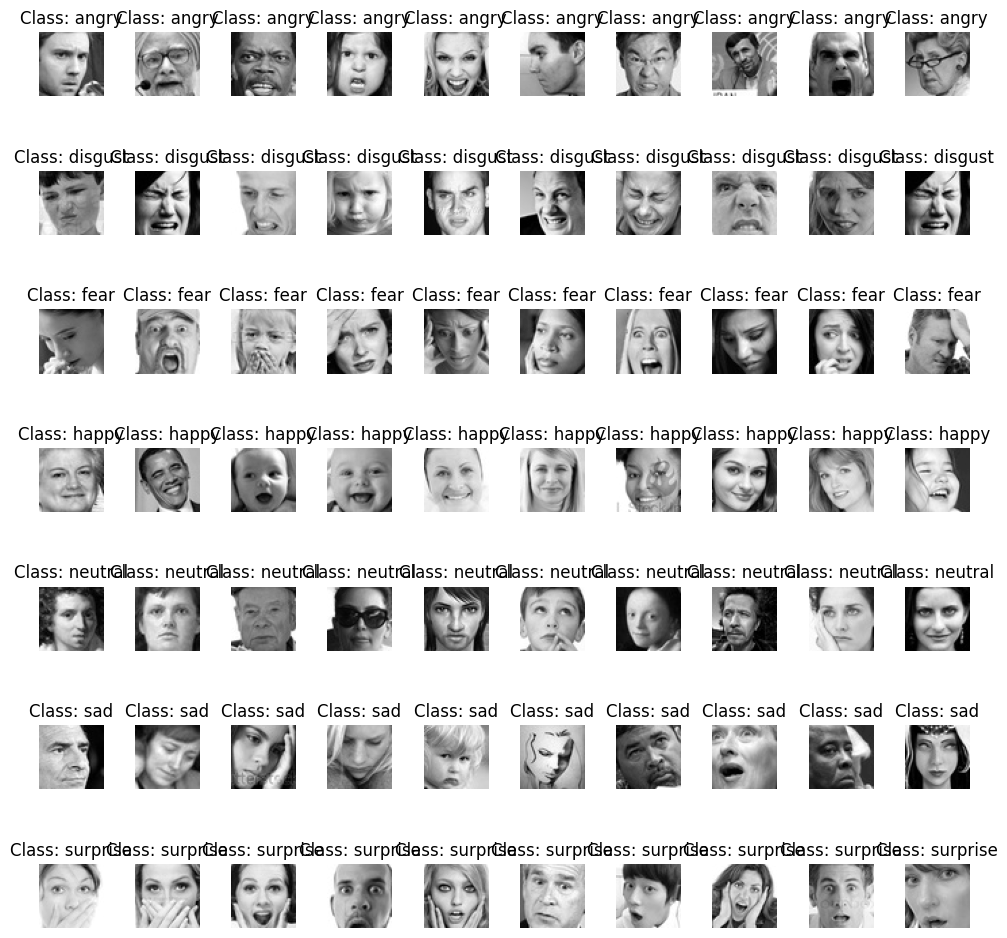

In [6]:
classes_to_plot = 7
images_per_class = 10
fig, axs = plt.subplots(classes_to_plot, images_per_class, figsize=(12, 12))

for i, label in enumerate(df['labels'].unique()):
    class_data = df[df['labels'] == label].head(images_per_class)
    for j, (_, row) in enumerate(class_data.iterrows()):
        ax = axs[i, j]
        ax.imshow(row['images'], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class: {label}')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

<Axes: xlabel='labels'>

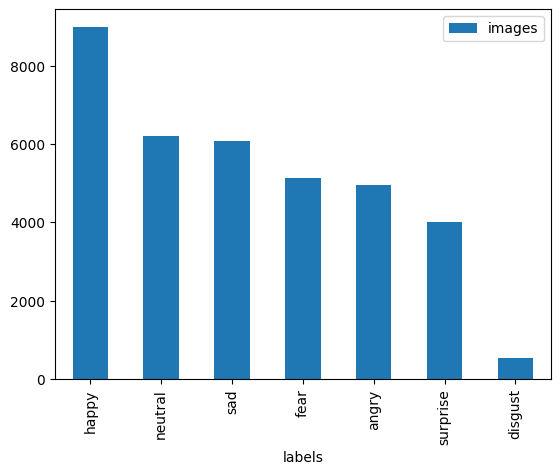

In [7]:
df.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [8]:
df=df.sample(frac=1,random_state=0)
train,temp=train_test_split(df, test_size=0.3, random_state=0,shuffle=True,stratify=df["labels"])
val,test=train_test_split(temp, test_size=0.3, random_state=0,shuffle=True,stratify=temp["labels"])

In [9]:
oversample=RandomOverSampler(sampling_strategy="auto",random_state=0)
X_over, y_over = oversample.fit_resample( train[["images"]], train[["labels"]])

In [10]:
frames = [X_over, y_over]
train_oversampled = pd.concat(frames,axis=1)
train_oversampled =train_oversampled.sample(frac=1,random_state=0)

In [11]:
train_oversampled

,images,labels
19959,"[[51, 60, 45, 31, 40, 39, 43, 41, 50, 78, 40, ...",fear
15414,"[[206, 173, 172, 177, 182, 168, 217, 170, 148,...",fear
2293,"[[27, 28, 24, 18, 14, 13, 16, 22, 35, 50, 59, ...",sad
41704,"[[187, 174, 154, 159, 159, 156, 152, 157, 158,...",surprise
8242,"[[3, 1, 20, 103, 217, 132, 134, 154, 104, 148,...",angry
...,...,...
30403,"[[66, 35, 11, 16, 36, 53, 71, 88, 105, 121, 13...",disgust
21243,"[[254, 252, 169, 88, 81, 56, 96, 89, 78, 73, 9...",happy
42613,"[[158, 137, 153, 171, 195, 205, 196, 195, 181,...",surprise
43567,"[[149, 146, 146, 153, 162, 164, 164, 165, 158,...",surprise


<Axes: xlabel='labels'>

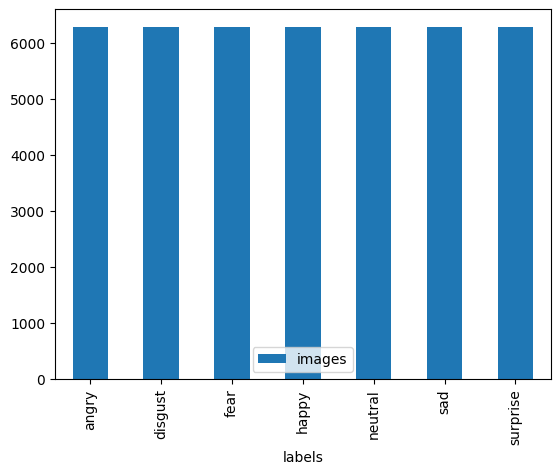

In [12]:
 train_oversampled.groupby(["labels"]).count().sort_values("images",ascending=False).plot(kind="bar")

In [13]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)
validation_datagen = ImageDataGenerator(
      # rescale the pixel values (between 0 and 255) to the [0,1] interval
       rescale=1./255
)

In [14]:
np.array(train_oversampled['labels'])

array(['fear', 'fear', 'sad', ..., 'surprise', 'surprise', 'angry'],
      dtype=object)

In [15]:
# Schritt 1: "images" in einen NumPy ndarray umwandeln
X_train = np.array(train_oversampled['images'].tolist())

# Schritt 2: "labels" in einen NumPy ndarray umwandeln
y_train = np.array(train_oversampled['labels'])

# Überprüfung der Form der erstellten Arrays
print("Shape von X_train:", X_train.shape)
print("Shape von y_train:", y_train.shape)

Shape von X_train: (44044, 48, 48)
Shape von y_train: (44044,)


In [16]:
train_oversampled['labels']

19959        fear
15414        fear
2293          sad
41704    surprise
8242        angry
           ...   
30403     disgust
21243       happy
42613    surprise
43567    surprise
2732        angry
Name: labels, Length: 44044, dtype: object

In [17]:
mapping = {'angry':0,
    'disgust':1,
    'fear':2,
    'happy':3,
    'neutral':4,
    'sad':5,
    'surprise':6}
train_oversampled['labels'] = train_oversampled['labels'].map(mapping)
#X_train = np.array(train_oversampled['images'].tolist()
X_train_plot=np.expand_dims(X_train[10].reshape((1,) + X_train[1].shape), axis=-1)
X_train=np.stack(train_oversampled["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_train=np.expand_dims(X_train, axis=-1)
y_train=train_oversampled["labels"].values

In [18]:
X_val=np.stack(val["images"].to_numpy())
#X_train = np.stack((X_train,) * 1, axis=-1)
X_val=np.expand_dims(X_val, axis=-1)
val["labels"]=val["labels"].map(mapping)
y_val=val["labels"].values

In [19]:
X_train_plot.shape

(1, 48, 48, 1)

In [20]:
y_train_cat=to_categorical(y_train)
y_train_cat

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
y_val_cat=to_categorical(y_val)


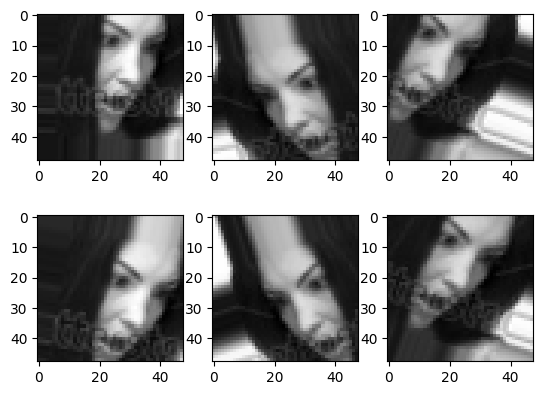

In [21]:
def plotImages(x):
    i = 1
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(2,3,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
        i += 1
        if i % 7 == 0:
            break
    plt.show()

plotImages(X_train_plot)

### Up to here, the same preparatory steps were done as for the other models.

# Part II - Get metricts vor best model -> 4th run

In [30]:
# load pretrained model for emotion detection
# locally:
#model_4th_run=tf.keras.models.load_model('C:/Users/eli/Nextcloud/HSLU/Vorlesungen/Computer_Vision_CVI03/Project/model_saves/4tht_run_VGG16_model.h5')
# on colab:model_4th_run=tf.keras.models.load_model('../content/drive/MyDrive/ComputerVision/Models/4tht_run_VGG16_model.h5')
model_1st_run=tf.keras.models.load_model('/content/drive/MyDrive/ComputerVision/Models/1st_run_VGG16_model.h5')
model_2nd_run=tf.keras.models.load_model('/content/drive/MyDrive/ComputerVision/Models/2nd_run_VGG16_model.h5')
model_3rd_run=tf.keras.models.load_model('/content/drive/MyDrive/ComputerVision/Models/3rd_run_VGG16_model.h5')

In [23]:
X_test=np.stack(test["images"].to_numpy())
X_test=np.expand_dims(X_test, axis=-1)
test["labels"]=test["labels"].map(mapping)
y_test=test["labels"].values

In [24]:
X_test.shape

(3231, 48, 48, 1)

In [25]:
# as VGG16 exppects 3 input channels, replicate the grey cahnnel to 3 channels
X_test_rgb = np.repeat(X_test, 3, -1)  # Replicate single channel to three channels
X_val_rgb = np.repeat(X_val, 3, -1)

In [26]:
X_test_rgb.shape

(3231, 48, 48, 3)

In [34]:
model_1st_run.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 9s 7ms/step - loss: 31.6766 - accuracy: 0.2260


[31.676607131958008, 0.2259819507598877]

In [35]:
model_2nd_run.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 2s 6ms/step - loss: 51.8741 - accuracy: 0.2286


[51.8741455078125, 0.22863587737083435]

In [36]:
model_3rd_run.evaluate(X_val_rgb, y_val_cat)

236/236 [==============================] - 2s 6ms/step - loss: 223.0939 - accuracy: 0.3560


[223.09385681152344, 0.3560244143009186]

In [37]:
model_4th_run.evaluate(X_val_rgb, y_val_cat)


236/236 [==============================] - 2s 7ms/step - loss: 147.5891 - accuracy: 0.3167


[147.58914184570312, 0.3167462944984436]

In [38]:
#predicted = model.predict(X_test)
predicted=np.argmax(model_3rd_run.predict(X_test_rgb), axis=1)
predicted

101/101 [==============================] - 1s 8ms/step


array([4, 4, 6, ..., 5, 4, 4])

In [39]:
remapping = {0:'angry',
    1:'disgust',
    2:'fear',
    3:'happy',
    4:'neutral',
    5:'sad',
    6:'surprise'}
predicted_remapped=pd.DataFrame(predicted)[0].map(remapping)
predicted_remapped

0        neutral
1        neutral
2       surprise
3            sad
4       surprise
          ...   
3226     neutral
3227     neutral
3228         sad
3229     neutral
3230     neutral
Name: 0, Length: 3231, dtype: object

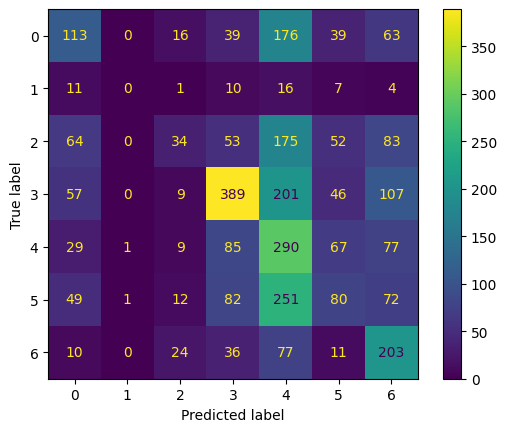

Accuracy: 0.34323738780563295
Recall: [0.25336323 0.         0.07375271 0.48084054 0.51971326 0.14625229
 0.56232687]
Precision: [0.33933934 0.         0.32380952 0.56051873 0.24451939 0.26490066
 0.33333333]
Precision: [0.29011553 0.         0.12014134 0.5176314  0.33256881 0.18845701
 0.4185567 ]


In [40]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve,accuracy_score, recall_score, precision_score,f1_score

cm=confusion_matrix(y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)#, display_labels = ["negative[0]", "Positive[1]"])

cm_display.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, predicted,average=None)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, predicted,average=None)
print("Precision:", precision)

f1 = f1_score(y_test, predicted,average=None)
print("Precision:", f1)
